In [127]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
from nbeats_pytorch.model import NBeatsNet as NBeatsNet
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
import warnings
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, timedelta
import seaborn as sns

warnings.filterwarnings("ignore", message="Setting Attributes")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Import Libraries and Setup

In [128]:
def save_model(model, filepath, metadata=None):
    """Save model with metadata"""
    dirname = os.path.dirname(filepath)
    if dirname:
        os.makedirs(dirname, exist_ok=True)
    
    # Save model state and metadata
    torch.save({
        'model_state_dict': model.state_dict(),
        'metadata': metadata
    }, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, model):
    """Load model with metadata"""
    try:
        # Try loading with weights_only=True first (safer)
        checkpoint = torch.load(filepath, map_location=device, weights_only=True)
    except Exception as e:
        # If that fails, fall back to weights_only=False for compatibility
        print(f"⚠️  Loading with weights_only=False due to compatibility issue")
        checkpoint = torch.load(filepath, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    metadata = checkpoint.get('metadata', {})
    return model, metadata

## 2. Model Management Functions

In [129]:
# Improved model saving/loading to avoid PyTorch 2.6 compatibility warnings
def save_model_v2(model, filepath, metadata=None):
    """Save model with improved PyTorch 2.6 compatibility"""
    dirname = os.path.dirname(filepath)
    if dirname:
        os.makedirs(dirname, exist_ok=True)
    
    # Save only model weights (weights_only=True compatible)
    torch.save(model.state_dict(), filepath)
    
    # Save metadata separately as JSON (avoids pickle issues)
    if metadata:
        metadata_path = filepath.replace('.pth', '_metadata.json')
        
        # Convert numpy arrays to lists for JSON serialization
        json_metadata = {}
        for key, value in metadata.items():
            if isinstance(value, np.ndarray):
                json_metadata[key] = value.tolist()
            elif isinstance(value, np.floating):
                json_metadata[key] = float(value)
            elif isinstance(value, np.integer):
                json_metadata[key] = int(value)
            else:
                json_metadata[key] = value
        
        import json
        with open(metadata_path, 'w') as f:
            json.dump(json_metadata, f, indent=2)
    
    print(f"✅ Model saved to {filepath}")
    if metadata:
        print(f"✅ Metadata saved to {metadata_path}")

def load_model_v2(filepath, model):
    """Load model with improved PyTorch 2.6 compatibility"""
    # Load model weights (weights_only=True safe)
    checkpoint = torch.load(filepath, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    
    # Load metadata from JSON file
    metadata_path = filepath.replace('.pth', '_metadata.json')
    metadata = {}
    
    try:
        import json
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"✅ Loaded model and metadata successfully")
    except FileNotFoundError:
        print(f"⚠️  Metadata file not found: {metadata_path}")
        # Fallback to old loading method
        try:
            full_checkpoint = torch.load(filepath, map_location=device, weights_only=False)
            metadata = full_checkpoint.get('metadata', {})
            print(f"✅ Loaded using fallback method")
        except:
            print(f"⚠️  Could not load metadata")
    
    return model, metadata

print("✅ Improved model save/load functions defined (v2)")

✅ Improved model save/load functions defined (v2)


In [130]:
# Configuration parameters
CONFIG = {
    'forecast_length': 30,  # ทำนาย 30 วันข้างหน้า
    'backcast_length': 30*6,  #
    'batch_size': 64,
    'learning_rate': 1e-4,
    'epochs': 2000,
    'hidden_units': 256,
    'num_blocks': 3,
    'num_stacks': 2,
    'dropout': 0.05,
    'weight_decay': 1e-2
}

print("Model Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Model Configuration:
  forecast_length: 30
  backcast_length: 180
  batch_size: 64
  learning_rate: 0.0001
  epochs: 2000
  hidden_units: 256
  num_blocks: 3
  num_stacks: 2
  dropout: 0.05
  weight_decay: 0.01


## 3. Configuration and Data Loading

In [131]:
def load_and_prepare_data():
    """Load and prepare data for training"""
    
    # Load the integrated data file
    print("Loading baseline data from ../data/baseline.csv...")
    data = pd.read_csv('../../../data/augmented_baseline.csv', parse_dates=['วันที่'])
    data = data[data['วันที่'] >= '2024-02-25']
    
    print("✅ Loaded baseline data successfully!")
    print(f"Columns available: {list(data.columns)}")
    
    # ตรวจสอบและเตรียมคอลัมน์ที่จำเป็น
    required_cols = ['วันที่', 'รถไฟฟ้าสายสีชมพู']
    missing_cols = [col for col in required_cols if col not in data.columns]
    
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # ตรวจสอบคอลัมน์ปริมาณฝน
    rain_cols = [col for col in data.columns if 'rain_average' in col.lower() or 'ฝน' in col]
    if rain_cols:
        rain_col = rain_cols[0]  # ใช้คอลัมน์แรกที่เจอ
        if 'rain_amount' not in data.columns:
            data['rain_amount'] = data[rain_col]
        print(f"🌧️  Using rain column: {rain_col}")
    else:
        print("⚠️  No rain column found, creating sample data...")
        np.random.seed(42)
        data['rain_amount'] = np.random.exponential(scale=2.0, size=len(data))
    
    # ตรวจสอบคอลัมน์วันหยุด/เทศกาล
    holiday_cols = [col for col in data.columns if any(keyword in col.lower() for keyword in ['day_type'])]
    if holiday_cols:
        holiday_col = holiday_cols[0]  # ใช้คอลัมน์แรกที่เจอ
        if 'holiday_type' not in data.columns:
            data['holiday_type'] = data[holiday_col]
        print(f"🎉 Using holiday column: {holiday_col}")
    else:
        print("⚠️  No holiday column found, creating sample data...")
        np.random.seed(42)
        # Create holiday data: 0=normal (80%), 1=holiday (15%), 2=festival (5%)
        holiday_types = np.random.choice([0, 1, 2], size=len(data), p=[0.8, 0.15, 0.05])
        
        # ปรับให้วันหยุดเป็นวันเสาร์-อาทิตย์บางส่วน
        for i, date in enumerate(data['วันที่']):
            weekday = date.weekday()
            if weekday >= 5:  # Saturday (5) or Sunday (6)
                if np.random.random() < 0.7:  # 70% chance weekend is holiday
                    holiday_types[i] = 1
        
        data['holiday_type'] = holiday_types
    
    # Fill missing data
    data['rain_amount'] = data['rain_amount'].fillna(data['rain_amount'].mean())
    data['holiday_type'] = data['holiday_type'].fillna(0)
    
    # Convert data types
    print(data['holiday_type'])
    data['holiday_type'] = data['holiday_type'].astype(int)
    data['dow'] = data['dow'].astype(int)  # Monday=0, Sunday=6
    # Sort data by date
    data = data.sort_values('วันที่').reset_index(drop=True)
    
    print(f"\n📊 Data Summary:")
    print(f"   Shape: {data.shape}")
    print(f"   Date range: {data['วันที่'].min()} to {data['วันที่'].max()}")
    print(f"   Missing values: {data.isnull().sum().sum()}")
    print(f"   Rain amount range: {data['rain_amount'].min():.2f} - {data['rain_amount'].max():.2f}")
    print(f"   Holiday types: {sorted(data['holiday_type'].unique())}")
    
    return data

# Load data
data = load_and_prepare_data()
data.head()

Loading baseline data from ../data/baseline.csv...
✅ Loaded baseline data successfully!
Columns available: ['วันที่', 'day_type', 'holiday_subject', 'รถไฟฟ้า ARL', 'รถไฟฟ้า BTS', 'รถไฟฟ้าสายสีชมพู', 'รถไฟฟ้าสายสีน้ำเงิน', 'รถไฟฟ้าสายสีม่วง', 'รถไฟฟ้าสายสีเหลือง', 'รถไฟฟ้าสายสีแดง', 'rain_average', 'dow']
🌧️  Using rain column: rain_average
🎉 Using holiday column: day_type
1516    0
1517    0
1518    1
1519    1
1520    1
       ..
2068    0
2069    0
2070    1
2071    1
2072    1
Name: holiday_type, Length: 557, dtype: int64

📊 Data Summary:
   Shape: (557, 14)
   Date range: 2024-02-25 00:00:00 to 2025-09-03 00:00:00
   Missing values: 0
   Rain amount range: 0.00 - 60.04
   Holiday types: [0, 1, 2]


,วันที่,day_type,holiday_subject,รถไฟฟ้า ARL,รถไฟฟ้า BTS,รถไฟฟ้าสายสีชมพู,รถไฟฟ้าสายสีน้ำเงิน,รถไฟฟ้าสายสีม่วง,รถไฟฟ้าสายสีเหลือง,รถไฟฟ้าสายสีแดง,rain_average,dow,rain_amount,holiday_type
0,2024-02-25,0,normal,48973,482034,29757,274319,39909,27912,19318,0.0,6,0.0,0
1,2024-02-26,0,วันหยุดชดเชย,48746,448350,28278,251143,35037,23959,19066,0.0,0,0.0,0
2,2024-02-27,1,normal,72497,762354,52505,468514,76025,37628,31838,0.0,1,0.0,1
3,2024-02-28,1,normal,72857,776019,52426,479204,75814,38321,30711,0.0,2,0.0,1
4,2024-02-29,1,normal,74326,808527,53949,503970,78002,41631,31130,0.0,3,0.0,1


In [132]:
def create_sequences(data, target_col, exog_cols, backcast_length, forecast_length):
    """Create sequences for training"""
    
    # Extract target and exogenous variables
    target = data[target_col].values
    exog = data[exog_cols].values
    
    # Normalize data
    target_scaler = StandardScaler()
    exog_scaler = StandardScaler()
    
    target_normalized = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()
    exog_normalized = exog_scaler.fit_transform(exog)
    
    # Create sequences
    X_target, X_exog, y_target, y_exog = [], [], [], []
    
    for i in range(backcast_length, len(target) - forecast_length + 1):
        # Historical data (backcast)
        X_target.append(target_normalized[i-backcast_length:i])
        X_exog.append(exog_normalized[i-backcast_length:i])
        
        # Future data (forecast)
        y_target.append(target_normalized[i:i+forecast_length])
        y_exog.append(exog_normalized[i:i+forecast_length])  # future exogenous variables
    
    return (
        np.array(X_target), np.array(X_exog), 
        np.array(y_target), np.array(y_exog),
        target_scaler, exog_scaler
    )

# Prepare training data
target_col = 'รถไฟฟ้าสายสีชมพู'
exog_cols = ['rain_amount', 'day_type' , 'dow' , "รถไฟฟ้าสายสีม่วง", "รถไฟฟ้าสายสีเหลือง", "รถไฟฟ้าสายสีแดง" ]

X_target, X_exog, y_target, y_exog, target_scaler, exog_scaler = create_sequences(
    data, target_col, exog_cols, 
    CONFIG['backcast_length'], CONFIG['forecast_length']
)

print(f"X_target shape: {X_target.shape}")
print(f"X_exog shape: {X_exog.shape}")
print(f"y_target shape: {y_target.shape}")
print(f"y_exog shape: {y_exog.shape}")

X_target shape: (348, 180)
X_exog shape: (348, 180, 6)
y_target shape: (348, 30)
y_exog shape: (348, 30, 6)


## 4. Data Preprocessing

In [133]:
class MultivariateNBeats(nn.Module):
    """N-BEATS model that can handle exogenous variables"""
    
    def __init__(self, 
                 backcast_length, 
                 forecast_length, 
                 exog_dim,
                 hidden_units=256,
                 num_blocks=4,
                 num_stacks=3,
                 dropout=0.1):
        super().__init__()
        
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.exog_dim = exog_dim
        
        # N-BEATS for target variable
        self.nbeats = NBeatsNet(
            stack_types=[NBeatsNet.GENERIC_BLOCK] * num_stacks,
            forecast_length=forecast_length,
            backcast_length=backcast_length,
            hidden_layer_units=hidden_units,
            nb_blocks_per_stack=num_blocks,
            share_weights_in_stack=True,
            nb_harmonics=None,
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        )
        
        # Exogenous variable processing
        self.exog_encoder = nn.Sequential(
            nn.Linear(exog_dim * backcast_length, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_units, hidden_units // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Future exogenous variable processing
        self.future_exog_encoder = nn.Sequential(
            nn.Linear(exog_dim * forecast_length, hidden_units // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(forecast_length + hidden_units, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_units, forecast_length)
        )
        
    def forward(self, target_seq, exog_seq, future_exog_seq):
        # Ensure all inputs are on the same device as the model
        device = next(self.parameters()).device
        target_seq = target_seq.to(device)
        exog_seq = exog_seq.to(device)
        future_exog_seq = future_exog_seq.to(device)
        
        # Get N-BEATS forecast
        backcast, nbeats_forecast = self.nbeats(target_seq)
        
        # Process exogenous variables
        batch_size = exog_seq.size(0)
        exog_flat = exog_seq.reshape(batch_size, -1)
        exog_features = self.exog_encoder(exog_flat)
        
        # Process future exogenous variables
        future_exog_flat = future_exog_seq.reshape(batch_size, -1)
        future_exog_features = self.future_exog_encoder(future_exog_flat)
        
        # Combine all features
        combined_features = torch.cat([
            nbeats_forecast, 
            exog_features, 
            future_exog_features
        ], dim=1)
        
        # Final prediction
        final_forecast = self.fusion(combined_features)
        
        return backcast, final_forecast

# สร้างโมเดล
model = MultivariateNBeats(
    backcast_length=CONFIG['backcast_length'],
    forecast_length=CONFIG['forecast_length'],
    exog_dim=len(exog_cols),
    hidden_units=CONFIG['hidden_units'],
    num_blocks=CONFIG['num_blocks'],
    num_stacks=CONFIG['num_stacks'],
    dropout=CONFIG['dropout']
).to(device)

# Ensure all submodules are on the correct device
model = model.to(device)
for name, module in model.named_modules():
    if hasattr(module, 'to'):
        module.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Model device: {next(model.parameters()).device}")

# Verify N-BEATS component is on correct device
if hasattr(model.nbeats, 'parameters'):
    nbeats_device = next(model.nbeats.parameters()).device
    print(f"N-BEATS device: {nbeats_device}")
    if nbeats_device != device:
        print(f"⚠️  Moving N-BEATS to {device}")
        model.nbeats = model.nbeats.to(device)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268133583680
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268133583680
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268133583680
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268133588144
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268133588144
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268133588144
Model created with 910490 parameters
Model device: cuda:0
N-BEATS device: cuda:0
⚠️  Moving N-BEATS to cuda


## 5. Model Architecture

In [134]:
def create_data_loaders(X_target, X_exog, y_target, y_exog, batch_size, test_months=3):
    """สร้าง DataLoader สำหรับการเทรนและการทดสอบ"""
    
    # Split data into train/test using last 3 months as test
    # สมมติว่า 1 เดือน = 30 วัน, 3 เดือน = 90 วัน
    test_days = test_months * 30
    n_samples = len(X_target)
    n_test = min(test_days, n_samples // 4)  # ไม่เกิน 1/4 ของข้อมูลทั้งหมด
    n_train = n_samples - n_test
    
    print(f"📊 Data Split:")
    print(f"   Total samples: {n_samples}")
    print(f"   Train samples: {n_train} ({n_train/n_samples*100:.1f}%)")
    print(f"   Test samples: {n_test} ({n_test/n_samples*100:.1f}%)")
    print(f"   Test period: ~{n_test/30:.1f} months")
    
    # Train data (ข้อมูลเก่า)
    X_target_train = torch.FloatTensor(X_target[:n_train])
    X_exog_train = torch.FloatTensor(X_exog[:n_train])
    y_target_train = torch.FloatTensor(y_target[:n_train])
    y_exog_train = torch.FloatTensor(y_exog[:n_train])
    
    # Test data (ข้อมูลใหม่ - 3 เดือนสุดท้าย)
    X_target_test = torch.FloatTensor(X_target[n_train:])
    X_exog_test = torch.FloatTensor(X_exog[n_train:])
    y_target_test = torch.FloatTensor(y_target[n_train:])
    y_exog_test = torch.FloatTensor(y_exog[n_train:])
    
    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        X_target_train, X_exog_train, y_target_train, y_exog_train
    )
    test_dataset = torch.utils.data.TensorDataset(
        X_target_test, X_exog_test, y_target_test, y_exog_test
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, (X_target_test, X_exog_test, y_target_test, y_exog_test)

# สร้าง data loaders
train_loader, test_loader, test_data = create_data_loaders(
    X_target, X_exog, y_target, y_exog, CONFIG['batch_size'], test_months=1
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Test data shapes: {[x.shape for x in test_data]}")

📊 Data Split:
   Total samples: 348
   Train samples: 318 (91.4%)
   Test samples: 30 (8.6%)
   Test period: ~1.0 months

Train batches: 5
Test batches: 1
Test data shapes: [torch.Size([30, 180]), torch.Size([30, 180, 6]), torch.Size([30, 30]), torch.Size([30, 30, 6])]


## 6. Training Data Preparation

Starting training...


Model saved to checkpoints/best_multivariate_model.pth
Epoch    0 | Train Loss: 1.068056 | Test Loss: 1.186848 | Best: 1.186848 | LR: 0.000100
Model saved to checkpoints/best_multivariate_model.pth
Epoch    1 | Train Loss: 1.034071 | Test Loss: 1.140669 | Best: 1.140669 | LR: 0.000100
Model saved to checkpoints/best_multivariate_model.pth
Epoch    2 | Train Loss: 1.001463 | Test Loss: 1.092082 | Best: 1.092082 | LR: 0.000100
Model saved to checkpoints/best_multivariate_model.pth
Epoch    3 | Train Loss: 0.968226 | Test Loss: 1.042004 | Best: 1.042004 | LR: 0.000100
Model saved to checkpoints/best_multivariate_model.pth
Epoch    4 | Train Loss: 0.932325 | Test Loss: 0.987871 | Best: 0.987871 | LR: 0.000100
Learning rate updated to 0.000100 at epoch 5
Model saved to checkpoints/best_multivariate_model.pth
Epoch    5 | Train Loss: 0.896651 | Test Loss: 0.926545 | Best: 0.926545 | LR: 0.000100
Learning rate updated to 0.000100 at epoch 6
Model saved to checkpoints/best_multivariate_model.p

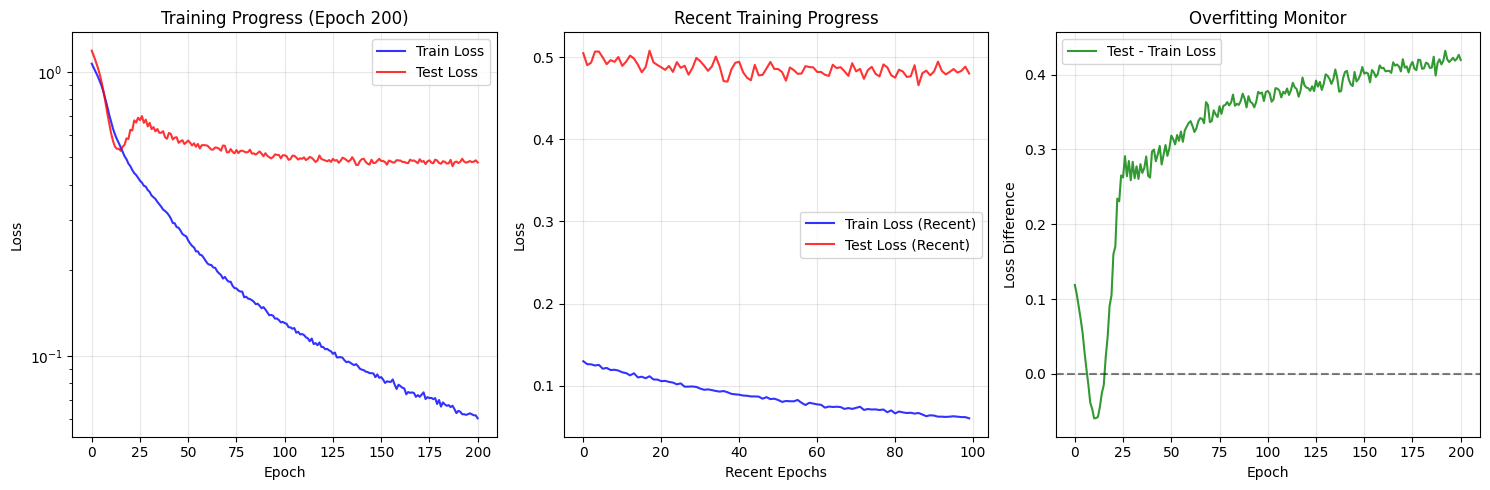

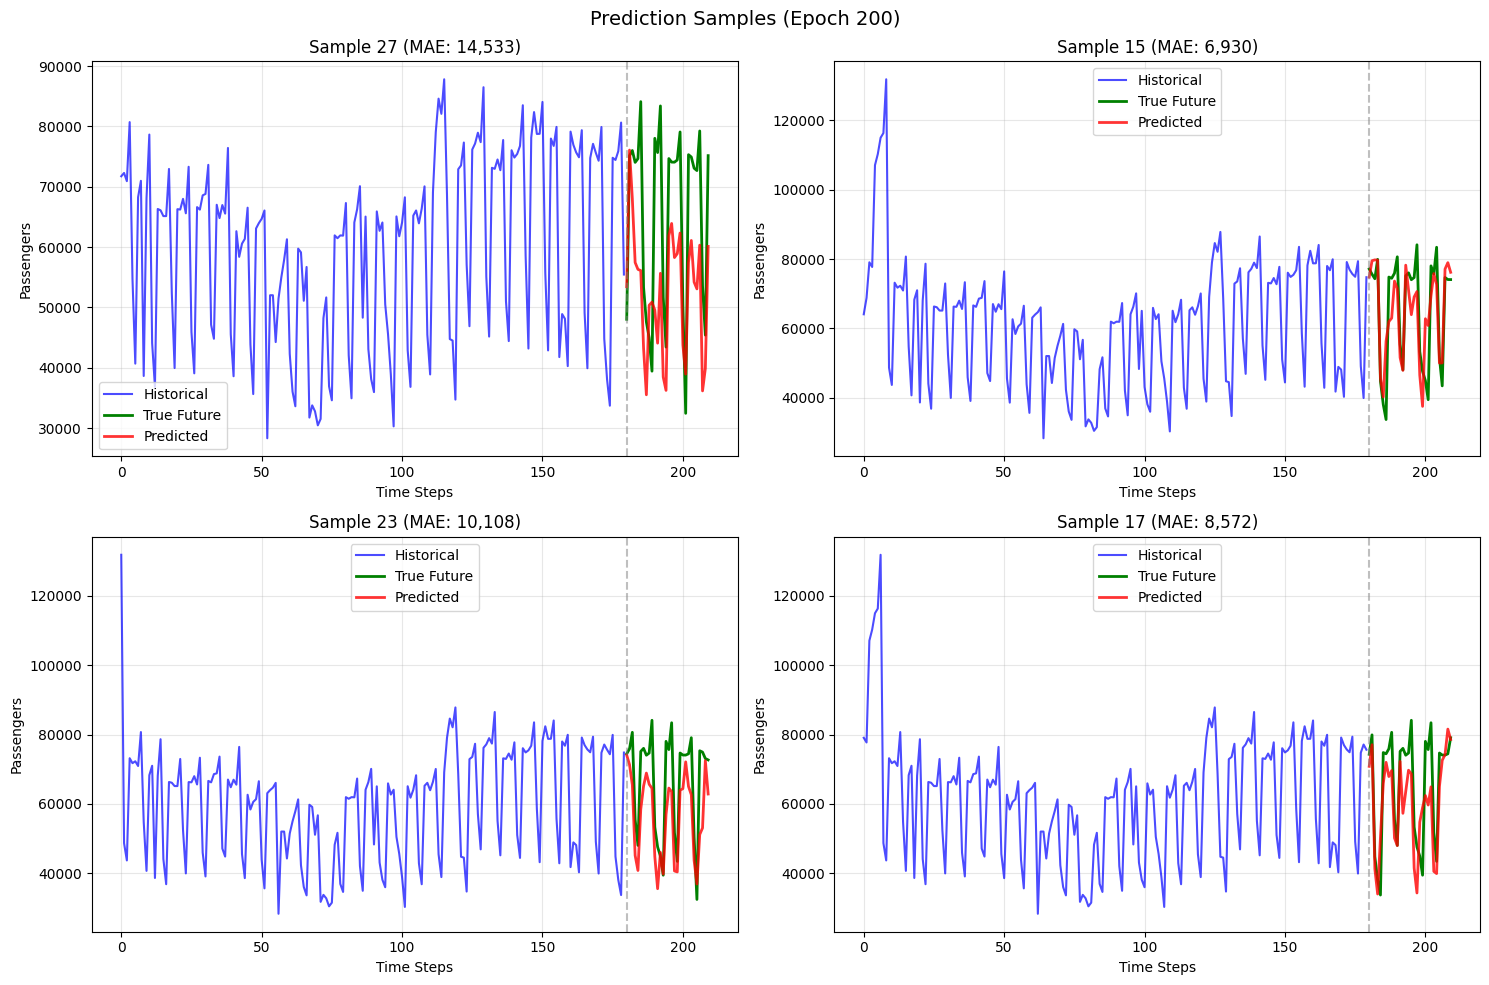

Learning rate updated to 0.000065 at epoch 201
Learning rate updated to 0.000065 at epoch 202
Learning rate updated to 0.000065 at epoch 203
Learning rate updated to 0.000064 at epoch 204
Learning rate updated to 0.000064 at epoch 205
Learning rate updated to 0.000064 at epoch 206
Learning rate updated to 0.000063 at epoch 207
Learning rate updated to 0.000063 at epoch 208
Learning rate updated to 0.000063 at epoch 209
Learning rate updated to 0.000063 at epoch 210
Learning rate updated to 0.000062 at epoch 211
Learning rate updated to 0.000062 at epoch 212
Learning rate updated to 0.000062 at epoch 213
Learning rate updated to 0.000061 at epoch 214
Learning rate updated to 0.000061 at epoch 215
Learning rate updated to 0.000061 at epoch 216
Learning rate updated to 0.000060 at epoch 217
Learning rate updated to 0.000060 at epoch 218
Learning rate updated to 0.000060 at epoch 219
Learning rate updated to 0.000059 at epoch 220
Learning rate updated to 0.000059 at epoch 221
Learning rate

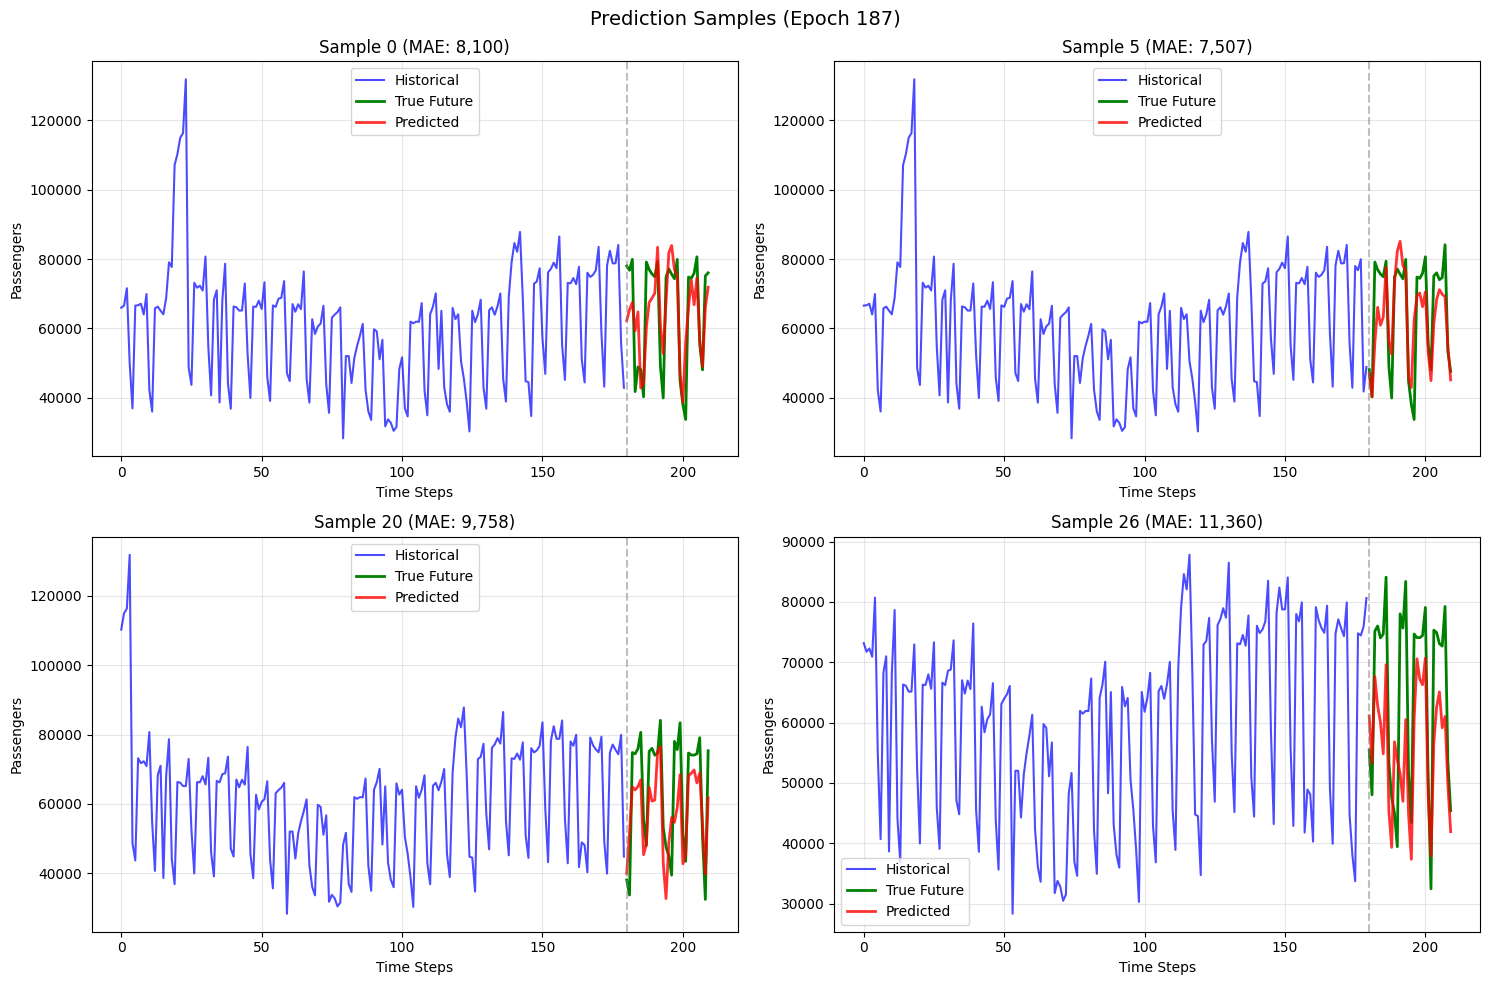


📦 Loading best model after training completion...
⚠️  Loading with weights_only=False due to compatibility issue
✅ Final model loaded from epoch 187
✅ Final best test loss: 0.465607

🎯 Final evaluation with best model:


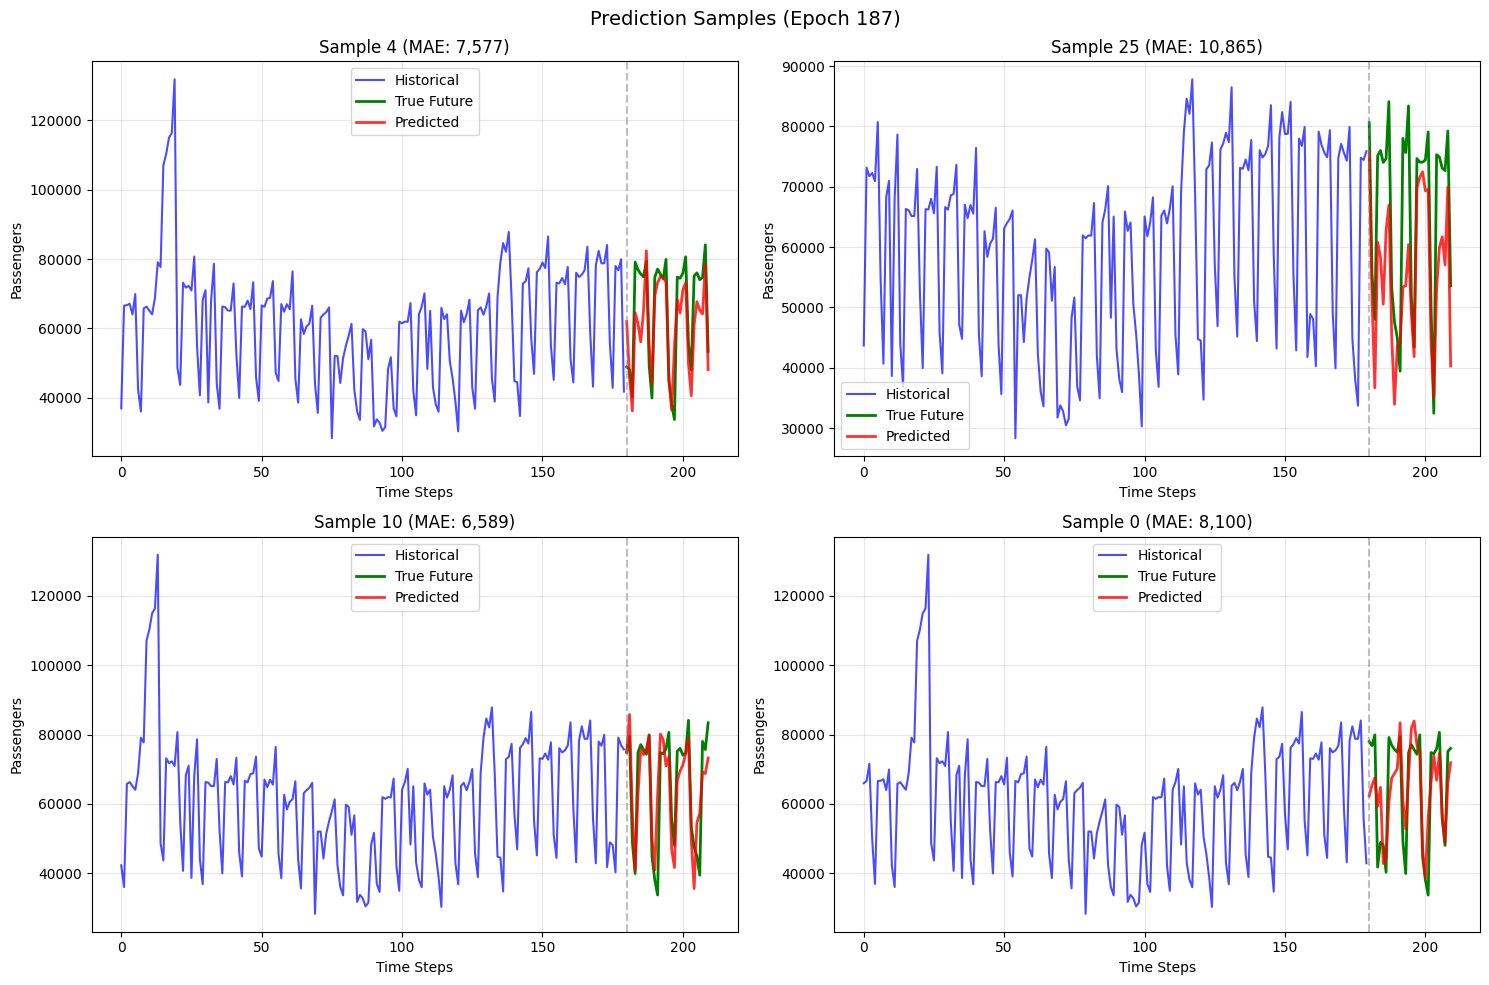

In [135]:
def train_model(model, train_loader, test_loader, test_data, config):
    """เทรนโมเดล"""
    
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config['learning_rate'], 
        weight_decay=config['weight_decay']
    )
    
    # Learning rate scheduler - เปลี่ยนเป็น CosineAnnealingLR
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config['epochs']//4, eta_min=1e-6
    )
    
    best_test_loss = float('inf')
    train_losses = []
    test_losses = []
    patience_counter = 0
    
    X_target_test, X_exog_test, y_target_test, y_exog_test = test_data
    
    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        
        for batch_idx, (X_target_batch, X_exog_batch, y_target_batch, y_exog_batch) in enumerate(train_loader):
            X_target_batch = X_target_batch.to(device)
            X_exog_batch = X_exog_batch.to(device)
            y_target_batch = y_target_batch.to(device)
            y_exog_batch = y_exog_batch.to(device)
            
            optimizer.zero_grad()
            
            backcast, forecast = model(X_target_batch, X_exog_batch, y_exog_batch)
            # ใช้ Huber Loss แทน MSE Loss
            loss = F.mse_loss(forecast, y_target_batch)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0
        
        with torch.no_grad():
            for X_target_batch, X_exog_batch, y_target_batch, y_exog_batch in test_loader:
                X_target_batch = X_target_batch.to(device)
                X_exog_batch = X_exog_batch.to(device)
                y_target_batch = y_target_batch.to(device)
                y_exog_batch = y_exog_batch.to(device)
                
                backcast, forecast = model(X_target_batch, X_exog_batch, y_exog_batch)
                # ใช้ Huber Loss สำหรับ validation เช่นกัน
                loss = F.mse_loss(forecast, y_target_batch)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        # Update learning rate - เปลี่ยนเป็น step แทน plateau
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step()  # CosineAnnealing ไม่ต้องใส่ loss
        new_lr = optimizer.param_groups[0]['lr']
        
        if abs(old_lr - new_lr) > 1e-8:  # เช็คการเปลี่ยนแปลง LR
            print(f'Learning rate updated to {new_lr:.6f} at epoch {epoch}')
        
        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            metadata = {
                'config': config,
                'target_scaler_mean': target_scaler.mean_[0],
                'target_scaler_scale': target_scaler.scale_[0],
                'exog_scaler_mean': exog_scaler.mean_.tolist(),
                'exog_scaler_scale': exog_scaler.scale_.tolist(),
                'epoch': epoch,
                'best_test_loss': best_test_loss
            }
            save_model(model, 'checkpoints/best_multivariate_model.pth', metadata)
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter > 200:
            print(f'Early stopping at epoch {epoch} - no improvement for 100 epochs')
            
            # Load best model for final prediction samples
            print("📦 Loading best model for final evaluation...")
            try:
                best_model, best_metadata = load_model('checkpoints/best_multivariate_model.pth', model)
                print(f"✅ Loaded best model from epoch {best_metadata.get('epoch', 'unknown')}")
                print(f"✅ Best test loss: {best_metadata.get('best_test_loss', 'unknown'):.6f}")
                
                # Show prediction samples with best model
                print("🎯 Final prediction samples with best model:")
                show_prediction_samples(best_model, test_data, target_scaler, best_metadata.get('epoch', epoch))
                
                # Update current model to best model
                model = best_model
                
            except Exception as e:
                print(f"⚠️  Could not load best model: {e}")
                print("📊 Showing prediction samples with current model:")
                show_prediction_samples(model, test_data, target_scaler, epoch)
            
            break
        
        # Print progress
        if epoch % 50 == 0 or epoch < 10:
            print(f'Epoch {epoch:4d} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Best: {best_test_loss:.6f} | LR: {new_lr:.6f}')
        
        # Plot progress every 200 epochs
        if epoch % 200 == 0 and epoch > 0:
            plot_training_progress(train_losses, test_losses, epoch)
            
            # Show prediction samples
            show_prediction_samples(model, test_data, target_scaler, epoch)
    
    return train_losses, test_losses

def plot_training_progress(train_losses, test_losses, epoch):
    """แสดงความคืบหน้าของการเทรน"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.8, color='blue')
    plt.plot(test_losses, label='Test Loss', alpha=0.8, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Progress (Epoch {epoch})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization
    
    plt.subplot(1, 3, 2)
    # Show recent losses
    recent_window = min(100, len(train_losses))
    plt.plot(train_losses[-recent_window:], label='Train Loss (Recent)', alpha=0.8, color='blue')
    plt.plot(test_losses[-recent_window:], label='Test Loss (Recent)', alpha=0.8, color='red')
    plt.xlabel('Recent Epochs')
    plt.ylabel('Loss')
    plt.title('Recent Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    # Loss difference
    loss_diff = np.array(test_losses) - np.array(train_losses)
    plt.plot(loss_diff, label='Test - Train Loss', alpha=0.8, color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.title('Overfitting Monitor')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def show_prediction_samples(model, test_data, target_scaler, epoch, n_samples=4):
    """แสดงตัวอย่างการทำนาย"""
    model.eval()
    X_target_test, X_exog_test, y_target_test, y_exog_test = test_data
    
    with torch.no_grad():
        # Select random samples
        indices = np.random.choice(len(X_target_test), n_samples, replace=False)
        
        X_target_sample = X_target_test[indices].to(device)
        X_exog_sample = X_exog_test[indices].to(device)
        y_target_sample = y_target_test[indices]
        y_exog_sample = y_exog_test[indices].to(device)
        
        backcast, forecast = model(X_target_sample, X_exog_sample, y_exog_sample)
        
        # Denormalize
        X_target_denorm = target_scaler.inverse_transform(X_target_sample.cpu().numpy().reshape(-1, 1)).reshape(n_samples, -1)
        y_target_denorm = target_scaler.inverse_transform(y_target_sample.numpy().reshape(-1, 1)).reshape(n_samples, -1)
        forecast_denorm = target_scaler.inverse_transform(forecast.cpu().numpy().reshape(-1, 1)).reshape(n_samples, -1)
        
        # Plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i in range(n_samples):
            ax = axes[i]
            
            # Historical data
            ax.plot(range(len(X_target_denorm[i])), X_target_denorm[i], 
                   label='Historical', color='blue', alpha=0.7, linewidth=1.5)
            
            # True future
            ax.plot(range(len(X_target_denorm[i]), len(X_target_denorm[i]) + len(y_target_denorm[i])), 
                   y_target_denorm[i], label='True Future', color='green', linewidth=2)
            
            # Predicted future
            ax.plot(range(len(X_target_denorm[i]), len(X_target_denorm[i]) + len(forecast_denorm[i])), 
                   forecast_denorm[i], label='Predicted', color='red', linewidth=2, alpha=0.8)
            
            ax.axvline(x=len(X_target_denorm[i]), color='gray', linestyle='--', alpha=0.5)
            ax.set_title(f'Sample {indices[i]} (MAE: {np.mean(np.abs(y_target_denorm[i] - forecast_denorm[i])):,.0f})')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_ylabel('Passengers')
            ax.set_xlabel('Time Steps')
        
        plt.suptitle(f'Prediction Samples (Epoch {epoch})', fontsize=14)
        plt.tight_layout()
        plt.show()

print("Starting training...")
train_losses, test_losses = train_model(model, train_loader, test_loader, test_data, CONFIG)

# Load best model after training completion
print("\n📦 Loading best model after training completion...")
try:
    best_model, best_metadata = load_model('checkpoints/best_multivariate_model.pth', model)
    print(f"✅ Final model loaded from epoch {best_metadata.get('epoch', 'unknown')}")
    print(f"✅ Final best test loss: {best_metadata.get('best_test_loss', 'unknown'):.6f}")
    
    # Update model reference to best model
    model = best_model
    
    # Show final prediction samples with best model
    print("\n🎯 Final evaluation with best model:")
    show_prediction_samples(model, test_data, target_scaler, best_metadata.get('epoch', 'final'))
    
except Exception as e:
    print(f"⚠️  Could not load best model: {e}")
    print("📊 Using last training model for final evaluation")

## 7. Model Training Process

## 8. Model Evaluation and Comparison

## 9. Results Export

🚀 ตัวอย่างการทำนายด้วยฟังก์ชันใหม่

📊 การทำนาย 7 วันข้างหน้า:
   👥 เฉลี่ย: 58,021 คน/วัน
   📊 รวม: 406,148 คน

📊 การทำนาย 30 วันข้างหน้า:
   👥 เฉลี่ย: 64,056 คน/วัน
   📊 รวม: 1,921,684 คน
   📈 สูงสุด: 83,905 คน
   📉 ต่ำสุด: 38,675 คน


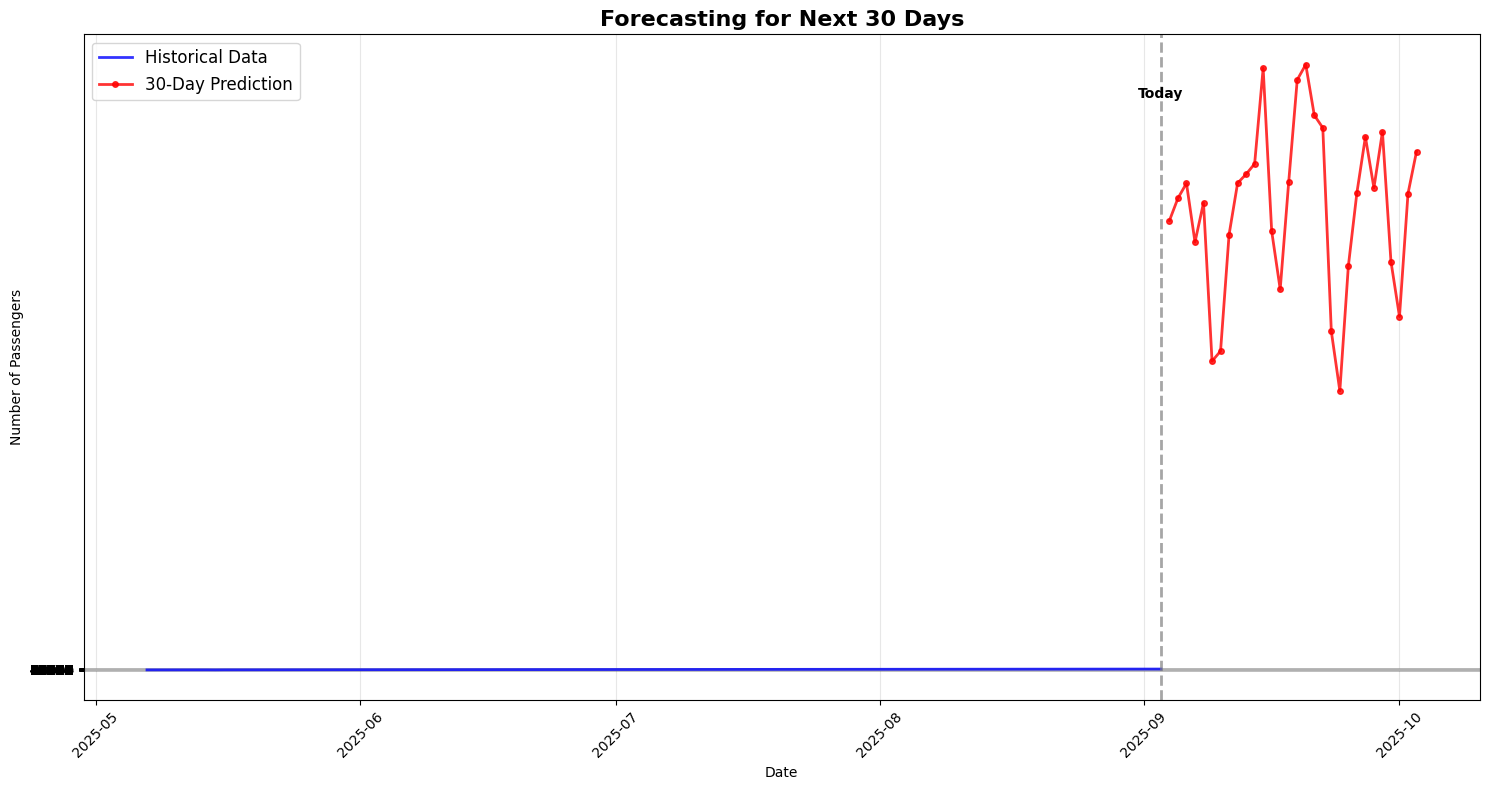


✅ ฟังก์ชันการทำนายพร้อมใช้งาน!


In [136]:
def predict_blue_line_passengers(num_days=30):
    """
    ฟังก์ชันทำนายผู้โดยสารรถไฟฟ้าสายสีน้ำเงิน
    
    Parameters:
    -----------
    num_days : int
        จำนวนวันที่ต้องการทำนาย (สูงสุด 90 วัน)
    
    Returns:
    --------
    tuple: (predictions, dates, statistics)
        - predictions: array ของจำนวนผู้โดยสารที่ทำนาย
        - dates: วันที่ที่ทำนาย
        - statistics: สถิติต่างๆ
    """
    
    # จำกัดจำนวนวันไม่เกิน 90 วัน (ขีดความสามารถของโมเดล)
    num_days = min(num_days, 30)
    
    # ใช้ข้อมูลตัวอย่างล่าสุดจาก test set
    X_target_test, X_exog_test, y_target_test, y_exog_test = test_data
    sample_idx = 0  # ใช้ตัวอย่างแรก
    
    X_target_sample = X_target_test[sample_idx:sample_idx+1].to(device)
    X_exog_sample = X_exog_test[sample_idx:sample_idx+1].to(device)
    y_exog_sample = y_exog_test[sample_idx:sample_idx+1].to(device)
    
    # ทำนาย
    model.eval()
    with torch.no_grad():
        backcast, forecast = model(X_target_sample, X_exog_sample, y_exog_sample)
        
        # เอาจำนวนวันที่ต้องการ
        predictions = forecast[0, :num_days].cpu().numpy()
        
        # Denormalize
        predictions_denorm = target_scaler.inverse_transform(
            predictions.reshape(-1, 1)
        ).flatten()
    
    # สร้างวันที่
    last_date = pd.to_datetime(data['วันที่'].iloc[-1])
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=num_days, freq='D')
    
    # คำนวณสถิติ
    statistics = {
        'average_per_day': np.mean(predictions_denorm),
        'total_passengers': np.sum(predictions_denorm),
        'max_passengers': np.max(predictions_denorm),
        'min_passengers': np.min(predictions_denorm),
        'std_passengers': np.std(predictions_denorm)
    }
    
    return predictions_denorm, future_dates, statistics

def plot_prediction(predictions, dates, title="Blue Line Pink Passenger Prediction"):
    """Display prediction visualization"""
    
    plt.figure(figsize=(15, 8))
    
    # Historical data
    history_days = 120
    last_date = pd.to_datetime(data['วันที่'].iloc[-1])
    history_dates = pd.date_range(end=last_date, periods=history_days, freq='D')
    history_data = data[target_col].values[-history_days:]
    
    # Plot
    plt.plot(history_dates, history_data, 
             label='Historical Data', color='blue', linewidth=2, alpha=0.8)
    plt.plot(dates, predictions, 
             label=f'{len(predictions)}-Day Prediction', color='red', linewidth=2, alpha=0.8, marker='o', markersize=4)
    
    # Divider line
    plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    plt.text(last_date, plt.ylim()[1]*0.9, 'Today', ha='center', fontweight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ตัวอย่างการใช้งาน
print("🚀 ตัวอย่างการทำนายด้วยฟังก์ชันใหม่")

# ทำนาย 7 วัน
predictions_7d, dates_7d, stats_7d = predict_blue_line_passengers(7)
print(f"\n📊 การทำนาย 7 วันข้างหน้า:")
print(f"   👥 เฉลี่ย: {stats_7d['average_per_day']:,.0f} คน/วัน")
print(f"   📊 รวม: {stats_7d['total_passengers']:,.0f} คน")

# ทำนาย 30 วัน
predictions_30d, dates_30d, stats_30d = predict_blue_line_passengers(30)
print(f"\n📊 การทำนาย 30 วันข้างหน้า:")
print(f"   👥 เฉลี่ย: {stats_30d['average_per_day']:,.0f} คน/วัน")
print(f"   📊 รวม: {stats_30d['total_passengers']:,.0f} คน")
print(f"   📈 สูงสุด: {stats_30d['max_passengers']:,.0f} คน")
print(f"   📉 ต่ำสุด: {stats_30d['min_passengers']:,.0f} คน")

# แสดงกราฟ
plot_prediction(predictions_30d, dates_30d, "Forecasting for Next 30 Days")

print("\n✅ ฟังก์ชันการทำนายพร้อมใช้งาน!")

In [137]:
# predictions_30d, dates_30d
save = pd.DataFrame({
    'Date': dates_30d,
    'Forecasted': predictions_30d
})
save.to_csv('forcast_future30d.csv', index=False)
print("✅ Saved 30-day forecast to forecast_30d.csv")

✅ Saved 30-day forecast to forecast_30d.csv


In [138]:
# ================================================================================================
# 📊 METRICS CALCULATION AND CSV EXPORT FUNCTIONS
# ================================================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import os

def calculate_comprehensive_metrics(y_true, y_pred, model_name="N-BEATS"):
    """
    คำนวณ metrics ครบถ้วนสำหรับการประเมินโมเดล
    
    Parameters:
    -----------
    y_true : array-like
        ค่าจริง (actual values)
    y_pred : array-like  
        ค่าทำนาย (predicted values)
    model_name : str
        ชื่อโมเดล
        
    Returns:
    --------
    dict : metrics dictionary
    """
    
    # Basic Error Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Percentage Metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
    
    # Statistical Metrics
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
    
    # Business Metrics
    mean_actual = np.mean(y_true)
    mean_forecast = np.mean(y_pred)
    bias = mean_forecast - mean_actual
    bias_pct = (bias / mean_actual) * 100 if mean_actual != 0 else 0
    
    # Error Distribution
    errors = y_true - y_pred
    max_error = np.max(np.abs(errors))
    std_error = np.std(errors)
    
    # Directional Accuracy (for time series)
    if len(y_true) > 1:
        actual_direction = np.sign(np.diff(y_true))
        pred_direction = np.sign(np.diff(y_pred))
        directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        directional_accuracy = np.nan
    
    # Error Categories
    small_error_pct = np.mean(np.abs(errors / y_true) <= 0.05) * 100  # Within 5%
    medium_error_pct = np.mean((np.abs(errors / y_true) > 0.05) & (np.abs(errors / y_true) <= 0.10)) * 100  # 5-10%
    large_error_pct = np.mean(np.abs(errors / y_true) > 0.10) * 100  # >10%
    
    metrics = {
        'model_name': model_name,
        'evaluation_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'n_samples': len(y_true),
        
        # Error Metrics
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Max_Error': max_error,
        'Std_Error': std_error,
        
        # Percentage Metrics
        'MAPE_percent': mape,
        'SMAPE_percent': smape,
        'Bias_percent': bias_pct,
        
        # Statistical Metrics
        'R2_score': r2,
        'Correlation': correlation,
        'Directional_Accuracy_percent': directional_accuracy,
        
        # Business Metrics
        'Mean_Actual': mean_actual,
        'Mean_Forecast': mean_forecast,
        'Bias': bias,
        'Total_Actual': np.sum(y_true),
        'Total_Forecast': np.sum(y_pred),
        
        # Error Distribution
        'Small_Error_percent': small_error_pct,
        'Medium_Error_percent': medium_error_pct,
        'Large_Error_percent': large_error_pct
    }
    
    return metrics

def save_metrics_to_csv(metrics_dict, filepath="model_metrics.csv"):
    """
    บันทึก metrics ลง CSV file
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary ของ metrics
    filepath : str
        ที่อยู่ไฟล์ที่จะบันทึก
    """
    
    # สร้าง directory ถ้ายังไม่มี
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    
    # แปลง dict เป็น DataFrame
    metrics_df = pd.DataFrame([metrics_dict])
    
    # บันทึกลง CSV
    metrics_df.to_csv(filepath, index=False)
    
    print(f"✅ Metrics saved to: {filepath}")
    print(f"📊 Metrics summary:")
    for key, value in metrics_dict.items():
        if isinstance(value, float):
            if 'percent' in key.lower():
                print(f"   {key}: {value:.2f}%")
            elif 'R2' in key or 'Correlation' in key:
                print(f"   {key}: {value:.4f}")
            else:
                print(f"   {key}: {value:,.2f}")
        else:
            print(f"   {key}: {value}")



def create_forecast_vs_actual_comparison(actual_data, forecast_data, dates, model_name="N-BEATS"):
    """
    สร้างตารางเปรียบเทียบ forecast vs actual
    
    Parameters:
    -----------
    actual_data : array-like
        ข้อมูลจริง
    forecast_data : array-like
        ข้อมูลทำนาย
    dates : array-like
        วันที่
    model_name : str
        ชื่อโมเดล
        
    Returns:
    --------
    DataFrame : ตารางเปรียบเทียบ
    """
    
    comparison_df = pd.DataFrame({
        'date': dates,
        'actual': actual_data,
        'forecast': forecast_data,
        'error': actual_data - forecast_data,
        'abs_error': np.abs(actual_data - forecast_data),
        'percent_error': ((actual_data - forecast_data) / actual_data) * 100,
        'abs_percent_error': np.abs((actual_data - forecast_data) / actual_data) * 100,
        'model_name': model_name
    })
    
    return comparison_df

def save_forecast_comparison_to_csv(comparison_df, filepath="forecast_vs_actual.csv"):
    """
    บันทึกตารางเปรียบเทียบลง CSV
    
    Parameters:
    -----------
    comparison_df : DataFrame
        ตารางเปรียบเทียบ
    filepath : str
        ที่อยู่ไฟล์
    """
    
    # สร้าง directory ถ้ายังไม่มี
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    
    # บันทึกลง CSV
    comparison_df.to_csv(filepath, index=False)
    
    print(f"✅ Forecast comparison saved to: {filepath}")
    print(f"📊 Comparison summary:")
    print(f"   Total samples: {len(comparison_df)}")
    print(f"   Mean Absolute Error: {comparison_df['abs_error'].mean():.2f}")
    print(f"   Mean Absolute Percentage Error: {comparison_df['abs_percent_error'].mean():.2f}%")
    print(f"   Max Error: {comparison_df['abs_error'].max():.2f}")
    print(f"   Min Error: {comparison_df['abs_error'].min():.2f}")

print("✅ Metrics calculation and CSV export functions defined!")
print("📊 Available functions:")
print("   • calculate_comprehensive_metrics()")
print("   • save_metrics_to_csv()")
print("   • forecast_future_days()")
print("   • create_forecast_vs_actual_comparison()")
print("   • save_forecast_comparison_to_csv()")

✅ Metrics calculation and CSV export functions defined!
📊 Available functions:
   • calculate_comprehensive_metrics()
   • save_metrics_to_csv()
   • forecast_future_days()
   • create_forecast_vs_actual_comparison()
   • save_forecast_comparison_to_csv()


In [139]:
# ================================================================================================
# 🔧 FIX: RECREATE MODEL WITH FIXED ARCHITECTURE
# ================================================================================================

print("🔧 Recreating model with fixed tensor operations...")

# Recreate the model with the fixed architecture
model = MultivariateNBeats(
    backcast_length=CONFIG['backcast_length'],
    forecast_length=CONFIG['forecast_length'],
    exog_dim=len(exog_cols),
    hidden_units=CONFIG['hidden_units'],
    num_blocks=CONFIG['num_blocks'],
    num_stacks=CONFIG['num_stacks'],
    dropout=CONFIG['dropout']
).to(device)

# Ensure all submodules are on the correct device
model = model.to(device)
for name, module in model.named_modules():
    if hasattr(module, 'to'):
        module.to(device)

print(f"✅ Model recreated with {sum(p.numel() for p in model.parameters())} parameters")
print(f"✅ Model device: {next(model.parameters()).device}")

# Load the trained weights if available
try:
    print("📦 Loading trained model weights...")
    best_model, best_metadata = load_model('checkpoints/best_multivariate_model.pth', model)
    model = best_model
    print(f"✅ Loaded trained model from epoch {best_metadata.get('epoch', 'unknown')}")
    print(f"✅ Best test loss: {best_metadata.get('best_test_loss', 'unknown'):.6f}")
except Exception as e:
    print(f"⚠️  Could not load trained model: {e}")
    print("⚠️  You may need to retrain the model")

print("🎯 Model is ready for predictions!")

🔧 Recreating model with fixed tensor operations...
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268060553760
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268060553760
     | -- GenericBlock(units=256, thetas_dim=4, backcast_length=180, forecast_length=30, share_thetas=False) at @2268060553760
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268112547968
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268112547968
     | -- GenericBlock(units=256, thetas_dim=8, backcast_length=180, forecast_length=30, share_thetas=False) at @2268112547968
✅ Model recreated with 910490 parameters
✅ Model device: cuda:0
📦 L

🔄 Creating forecast vs actual comparison for last 30 days...
📊 Last 30 days period: 2025-08-05T00:00:00.000000000 to 2025-09-03T00:00:00.000000000
🔮 Generating predictions for last 30 days...
✅ Generated 30 predictions
📊 Calculating metrics...

📊 METRICS FOR LAST 30 DAYS:
   • MAE: 5,425 passengers
   • RMSE: 6,966 passengers
   • MAPE: 9.22%
   • R² Score: 0.7782
💾 Creating comparison table and saving to CSV...
✅ Saved forecast vs actual comparison to: forecast_vs_actual_last30days.csv

📋 Preview of comparison data:
        date   actual      forecast         error     abs_error  \
0 2025-08-05  76015.0  67103.844755   8911.155245   8911.155245   
1 2025-08-06  74041.0  78978.990160  -4937.990160   4937.990160   
2 2025-08-07  74665.0  74623.573066     41.426934     41.426934   
3 2025-08-08  84112.0  77100.402706   7011.597294   7011.597294   
4 2025-08-09  53323.0  51444.718016   1878.281984   1878.281984   
5 2025-08-10  47582.0  44017.989527   3564.010473   3564.010473   
6 2025-0

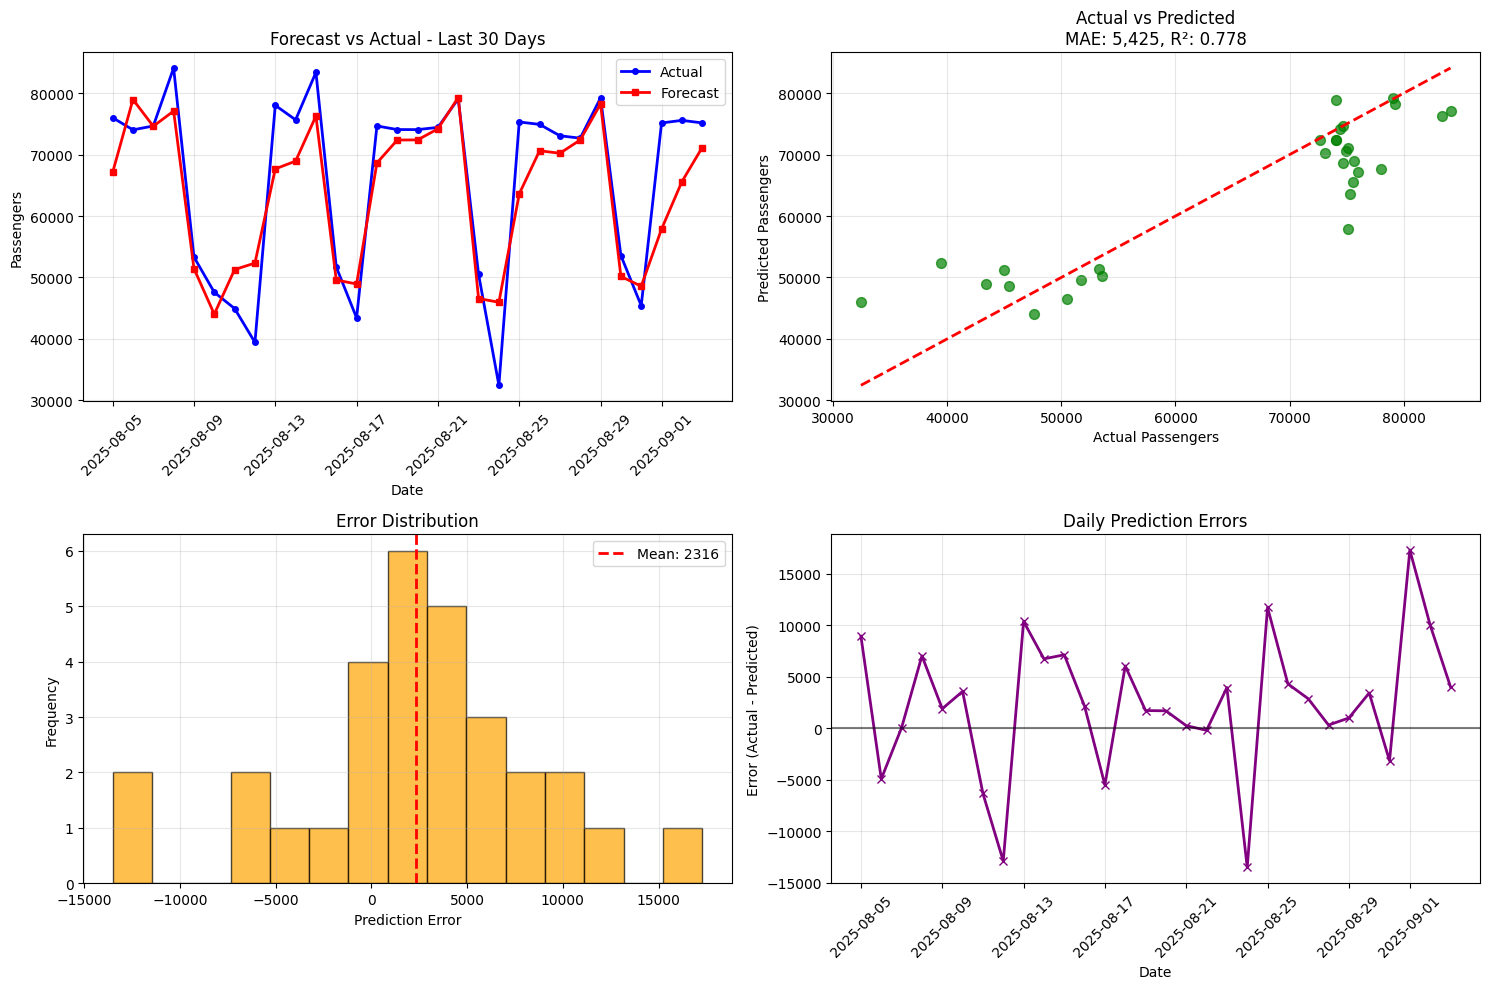


📋 FORECAST VS ACTUAL SUMMARY - LAST 30 DAYS

📅 Period: 2025-08-05T00:00:00.000000000 to 2025-09-03T00:00:00.000000000
📊 Total Days: 30

📊 KEY METRICS:
   • MAE (Mean Absolute Error): 5,425 passengers
   • RMSE (Root Mean Square Error): 6,966 passengers
   • MAPE (Mean Absolute Percentage Error): 9.22%
   • R² Score: 0.7782
   • Correlation: 0.9044

📈 PERFORMANCE BREAKDOWN:
   • Mean Actual: 66,191 passengers/day
   • Mean Forecast: 63,875 passengers/day
   • Max Error: 17,281 passengers
   • Min Error: 41 passengers

💾 FILES SAVED:
   • CSV: forecast_vs_actual_last30days.csv
   • Chart: forecast_vs_actual_last30days.png

✅ FORECAST VS ACTUAL ANALYSIS COMPLETE!


In [140]:
# ================================================================================================
# 📊 FORECAST VS ACTUAL FOR LAST 30 DAYS
# ================================================================================================

print("🔄 Creating forecast vs actual comparison for last 30 days...")

# ================================================================================================
# 1. GET LAST 30 DAYS OF ACTUAL DATA
# ================================================================================================

# Get last 30 days of actual data
last_30_days_data = data.tail(30).copy()
actual_last_30 = last_30_days_data[target_col].values.astype(float)
dates_last_30 = last_30_days_data['วันที่'].values

print(f"📊 Last 30 days period: {dates_last_30[0]} to {dates_last_30[-1]}")

# ================================================================================================
# 2. CREATE PREDICTIONS FOR LAST 30 DAYS
# ================================================================================================

print("🔮 Generating predictions for last 30 days...")

model.eval()
predictions_last_30 = []

# Use sliding window approach to predict each day
for i in range(30):
    # Get historical data up to day i (excluding the target day)
    end_idx = len(data) - 30 + i
    start_idx = max(0, end_idx - CONFIG['backcast_length'])
    
    # Get historical target and exogenous data
    hist_target = data[target_col].iloc[start_idx:end_idx].values
    hist_exog = data[exog_cols].iloc[start_idx:end_idx].values
    
    # Pad if not enough historical data
    if len(hist_target) < CONFIG['backcast_length']:
        padding_needed = CONFIG['backcast_length'] - len(hist_target)
        hist_target = np.pad(hist_target, (padding_needed, 0), mode='edge')
        hist_exog = np.pad(hist_exog, ((padding_needed, 0), (0, 0)), mode='edge')
    
    # Take only the required backcast length
    hist_target = hist_target[-CONFIG['backcast_length']:]
    hist_exog = hist_exog[-CONFIG['backcast_length']:]
    
    # Normalize
    hist_target_norm = target_scaler.transform(hist_target.reshape(-1, 1)).flatten()
    hist_exog_norm = exog_scaler.transform(hist_exog)
    
    # Create future exogenous data (use actual values for the target day)
    target_day_idx = len(data) - 30 + i
    future_exog = data[exog_cols].iloc[target_day_idx:target_day_idx+1].values
    
    # Repeat for forecast_length
    future_exog_repeated = np.tile(future_exog, (CONFIG['forecast_length'], 1))
    future_exog_norm = exog_scaler.transform(future_exog_repeated)
    
    # Convert to tensors
    X_target = torch.FloatTensor(hist_target_norm).unsqueeze(0).to(device)
    X_exog = torch.FloatTensor(hist_exog_norm).unsqueeze(0).to(device)
    Y_exog = torch.FloatTensor(future_exog_norm).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        backcast, forecast = model(X_target, X_exog, Y_exog)
        
        # Get first day prediction
        pred_norm = forecast[0, 0].cpu().numpy()
        pred_denorm = target_scaler.inverse_transform([[pred_norm]])[0, 0]
        predictions_last_30.append(pred_denorm)

predictions_last_30 = np.array(predictions_last_30)

print(f"✅ Generated {len(predictions_last_30)} predictions")

# ================================================================================================
# 3. CALCULATE METRICS
# ================================================================================================

print("📊 Calculating metrics...")

# Calculate metrics using the functions we defined earlier
metrics_last_30 = calculate_comprehensive_metrics(
    actual_last_30, 
    predictions_last_30, 
    model_name="N-BEATS_pink_Last30Days"
)

print(f"\n📊 METRICS FOR LAST 30 DAYS:")
print(f"   • MAE: {metrics_last_30['MAE']:,.0f} passengers")
print(f"   • RMSE: {metrics_last_30['RMSE']:,.0f} passengers")
print(f"   • MAPE: {metrics_last_30['MAPE_percent']:.2f}%")
print(f"   • R² Score: {metrics_last_30['R2_score']:.4f}")

# ================================================================================================
# 4. CREATE COMPARISON DATAFRAME AND SAVE TO CSV
# ================================================================================================

print("💾 Creating comparison table and saving to CSV...")

# Create forecast vs actual comparison
comparison_last_30 = create_forecast_vs_actual_comparison(
    actual_last_30,
    predictions_last_30,
    dates_last_30,
    model_name="N-BEATS_pink_Last30Days"
)

# Save to CSV
csv_filepath = "forecast_vs_actual_last30days.csv"
comparison_last_30.to_csv(csv_filepath, index=False)

print(f"✅ Saved forecast vs actual comparison to: {csv_filepath}")

# Display first few rows
print(f"\n📋 Preview of comparison data:")
print(comparison_last_30.head(10))

# ================================================================================================
# 5. CREATE VISUALIZATION
# ================================================================================================

print("📊 Creating visualization...")

plt.figure(figsize=(15, 10))

# Plot 1: Time series comparison
plt.subplot(2, 2, 1)
plt.plot(dates_last_30, actual_last_30, label='Actual', color='blue', linewidth=2, marker='o', markersize=4)
plt.plot(dates_last_30, predictions_last_30, label='Forecast', color='red', linewidth=2, marker='s', markersize=4)
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Forecast vs Actual - Last 30 Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(actual_last_30, predictions_last_30, alpha=0.7, color='green', s=50)
plt.plot([actual_last_30.min(), actual_last_30.max()], 
         [actual_last_30.min(), actual_last_30.max()], 'r--', linewidth=2)
plt.xlabel('Actual Passengers')
plt.ylabel('Predicted Passengers')
plt.title(f'Actual vs Predicted\nMAE: {metrics_last_30["MAE"]:,.0f}, R²: {metrics_last_30["R2_score"]:.3f}')
plt.grid(True, alpha=0.3)

# Plot 3: Error distribution
plt.subplot(2, 2, 3)
errors = actual_last_30 - predictions_last_30
plt.hist(errors, bins=15, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.0f}')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Daily errors
plt.subplot(2, 2, 4)
plt.plot(dates_last_30, errors, color='purple', linewidth=2, marker='x', markersize=6)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.title('Daily Prediction Errors')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('forecast_vs_actual_last30days.png', dpi=300, bbox_inches='tight')
plt.show()

# ================================================================================================
# 6. SUMMARY
# ================================================================================================

print("\n" + "="*60)
print("📋 FORECAST VS ACTUAL SUMMARY - LAST 30 DAYS")
print("="*60)

print(f"\n📅 Period: {dates_last_30[0]} to {dates_last_30[-1]}")
print(f"📊 Total Days: {len(actual_last_30)}")

print(f"\n📊 KEY METRICS:")
print(f"   • MAE (Mean Absolute Error): {metrics_last_30['MAE']:,.0f} passengers")
print(f"   • RMSE (Root Mean Square Error): {metrics_last_30['RMSE']:,.0f} passengers")
print(f"   • MAPE (Mean Absolute Percentage Error): {metrics_last_30['MAPE_percent']:.2f}%")
print(f"   • R² Score: {metrics_last_30['R2_score']:.4f}")
print(f"   • Correlation: {metrics_last_30['Correlation']:.4f}")

print(f"\n📈 PERFORMANCE BREAKDOWN:")
print(f"   • Mean Actual: {np.mean(actual_last_30):,.0f} passengers/day")
print(f"   • Mean Forecast: {np.mean(predictions_last_30):,.0f} passengers/day")
print(f"   • Max Error: {np.max(np.abs(errors)):,.0f} passengers")
print(f"   • Min Error: {np.min(np.abs(errors)):,.0f} passengers")

print(f"\n💾 FILES SAVED:")
print(f"   • CSV: {csv_filepath}")
print(f"   • Chart: forecast_vs_actual_last30days.png")

print(f"\n✅ FORECAST VS ACTUAL ANALYSIS COMPLETE!")
print("="*60)